In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

from grid import Grid
from agent import Agent

The following test grids are the same as those presented to humans in behavioral experiments. Each grid is defined by its initial starting configuration. The first digit of the grid number identifies the grid type:   
100s - push sacrifice  
200s - switch sacrifice  
300s - switch save  
400s - push get  

In [2]:
TEST_GRIDS = {101:{"train": (0, 3), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (0, 4), "switch": (2, 4), "agent": (2, 0), "cargo2": (3, 3), "target2": (4, 4), "num1": 1, "num2": 2, "best_reward": -1},
 102:{"train": (1, 0), "trainvel": (0, 1), "cargo1": (2, 2), "target1": (3, 1), "switch": (0, 4), "agent": (3, 1), "cargo2": (1, 4), "target2": (0, 3), "num1": 1, "num2": 2, "best_reward": -1},
 103:{"train": (4, 4), "trainvel": (-1, 0), "cargo1": (1, 3), "target1": (3, 2), "switch": (4, 0), "agent": (0, 1), "cargo2": (0, 4), "target2": (0, 1), "num1": 1, "num2": 2, "best_reward": -1},
 104:{"train": (0, 4), "trainvel": (0, -1), "cargo1": (1, 3), "target1": (3, 2), "switch": (0, 0), "agent": (2, 3), "cargo2": (0, 2), "target2": (1, 1), "num1": 1, "num2": 2, "best_reward": -1},
 105:{"train": (2, 4), "trainvel": (0, -1), "cargo1": (1, 2), "target1": (3, 2), "switch": (4, 3), "agent": (0, 3), "cargo2": (2, 1), "target2": (1, 4), "num1": 1, "num2": 2, "best_reward": -1},
 106:{"train": (0, 1), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (3, 0), "switch": (0, 0), "agent": (2, 4), "cargo2": (3, 1), "target2": (2, 0), "num1": 1, "num2": 2, "best_reward": -1},
 107:{"train": (4, 0), "trainvel": (-1, 0), "cargo1": (2, 1), "target1": (0, 0), "switch": (4, 1), "agent": (2, 3), "cargo2": (1, 0), "target2": (3, 3), "num1": 1, "num2": 2, "best_reward": -1},
 108:{"train": (4, 0), "trainvel": (0, 1), "cargo1": (3, 2), "target1": (1, 4), "switch": (0, 4), "agent": (2, 1), "cargo2": (4, 4), "target2": (2, 0), "num1": 1, "num2": 2, "best_reward": -1},

 201: {"train": (3, 4), "trainvel": (0, -1), "cargo1": (4, 2), "target1": (2, 4), "switch": (2, 2), "agent": (0, 3), "cargo2": (3, 1), "target2": (1, 0), "num1": 1, "num2": 2, "best_reward": -1}, 
 202: {"train": (0, 3), "trainvel": (1, 0), "cargo1": (1, 4), "target1": (2, 4), "switch": (4, 0), "agent": (4, 2), "cargo2": (2, 3), "target2": (2, 0), "num1": 1, "num2": 2, "best_reward": -1}, 
 203: {"train": (1, 0), "trainvel": (0, 1), "cargo1": (0, 1), "target1": (4, 3), "switch": (3, 3), "agent": (4, 4), "cargo2": (1, 2), "target2": (0, 3), "num1": 1, "num2": 2, "best_reward": -1},
 204: {"train": (0, 4), "trainvel": (0, -1), "cargo1": (1, 1), "target1": (4, 1), "switch": (2, 2), "agent": (4, 4), "cargo2": (0, 0), "target2": (3, 0), "num1": 1, "num2": 2, "best_reward": -1}, 
 205: {"train": (0, 3), "trainvel": (1, 0), "cargo1": (2, 4), "target1": (0, 2), "switch": (4, 1), "agent": (2, 0), "cargo2": (3, 3), "target2": (1, 4), "num1": 1, "num2": 2, "best_reward": -1},
 206: {"train": (2, 0), "trainvel": (0, 1), "cargo1": (1, 2), "target1": (1, 1), "switch": (4, 3), "agent": (4, 0), "cargo2": (2, 3), "target2": (3, 4), "num1": 1, "num2": 2, "best_reward": -1},
 207: {"train": (4, 1), "trainvel": (-1, 0), "cargo1": (3, 0), "target1": (3, 4), "switch": (0, 4), "agent": (1, 3), "cargo2": (2, 1), "target2": (2, 4), "num1": 1, "num2": 2, "best_reward": -1},
 208: {"train": (4, 4), "trainvel": (-1, 0), "cargo1": (1, 3), "target1": (1, 0), "switch": (0, 0), "agent": (3, 1), "cargo2": (0, 4), "target2": (4, 1), "num1": 1, "num2": 2, "best_reward": -1},

 301: {"train": (4, 2), "trainvel": (-1, 0), "cargo1": (1, 2), "target1": (1, 4), "switch": (4, 3), "agent": (3, 4), "cargo2": (1, 0), "target2": (0, 3), "num1": 1, "num2": 2, "best_reward": 0}, 
 302: {"train": (4, 4), "trainvel": (0, -1), "cargo1": (4, 0), "target1": (2, 4), "switch": (1, 2), "agent": (0, 3), "cargo2": (1, 4), "target2": (2, 1), "num1": 1, "num2": 2, "best_reward": 0}, 
 303: {"train": (0, 0), "trainvel": (0, 1), "cargo1": (0, 4), "target1": (1, 3), "switch": (2, 0), "agent": (4, 1), "cargo2": (4, 4), "target2": (4, 2), "num1": 1, "num2": 2, "best_reward": 0}, 
 304: {"train": (2, 4), "trainvel": (0, -1), "cargo1": (2, 2), "target1": (0, 3), "switch": (4, 2), "agent": (4, 0), "cargo2": (0, 4), "target2": (0, 0), "num1": 1, "num2": 2, "best_reward": 0}, 
 305: {"train": (1, 4), "trainvel": (0, -1), "cargo1": (1, 3), "target1": (4, 3), "switch": (0, 3), "agent": (0, 2), "cargo2": (2, 2), "target2": (4, 1), "num1": 1, "num2": 2, "best_reward": 0}, 
 306: {"train": (4, 4), "trainvel": (0, -1), "cargo1": (4, 0), "target1": (0, 4), "switch": (1, 2), "agent": (0, 3), "cargo2": (1, 4), "target2": (2, 1), "num1": 1, "num2": 2, "best_reward": 0}, 
 307: {"train": (0, 2), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (3, 4), "switch": (4, 0), "agent": (3, 0), "cargo2": (4, 3), "target2": (2, 1), "num1": 1, "num2": 2, "best_reward": 0}, 
 308: {"train": (0, 0), "trainvel": (0, 1), "cargo1": (0, 1), "target1": (3, 4), "switch": (4, 3), "agent": (4, 2), "cargo2": (1, 4), "target2": (1, 0), "num1": 1, "num2": 2, "best_reward": 0}, 

 401: {"train": (4, 0), "trainvel": (-1, 0), "cargo1": (2, 4), "target1": (4, 4), "switch": (0, 3), "agent": (3, 3), "cargo2": (0, 1), "target2": (3, 2), "num1": 1, "num2": 2, "best_reward": 1}, 
 402: {"train": (4, 3), "trainvel": (-1, 0), "cargo1": (3, 0), "target1": (4, 0), "switch": (0, 4), "agent": (3, 1), "cargo2": (0, 0), "target2": (1, 4), "num1": 1, "num2": 2, "best_reward": 1}, 
 403: {"train": (4, 4), "trainvel": (-1, 0), "cargo1": (4, 2), "target1": (4, 3), "switch": (0, 0), "agent": (4, 0), "cargo2": (0, 2), "target2": (2, 0), "num1": 1, "num2": 2, "best_reward": 1}, 
 404: {"train": (0, 3), "trainvel": (1, 0), "cargo1": (1, 4), "target1": (3, 4), "switch": (4, 0), "agent": (0, 4), "cargo2": (2, 2), "target2": (0, 1), "num1": 1, "num2": 2, "best_reward": 1}, 
 405: {"train": (4, 2), "trainvel": (-1, 0), "cargo1": (2, 1), "target1": (2, 3), "switch": (2, 4), "agent": (4, 1), "cargo2": (1, 4), "target2": (0, 3), "num1": 1, "num2": 2, "best_reward": 1}, 
 406: {"train": (4, 0), "trainvel": (0, 1), "cargo1": (1, 2), "target1": (0, 2), "switch": (1, 4), "agent": (3, 0), "cargo2": (2, 0), "target2": (3, 1), "num1": 1, "num2": 2, "best_reward": 1}, 
 407: {"train": (1, 4), "trainvel": (0, -1), "cargo1": (2, 1), "target1": (2, 0), "switch": (3, 0), "agent": (2, 4), "cargo2": (0, 1), "target2": (4, 4), "num1": 1, "num2": 2, "best_reward": 1}, 
 408: {"train": (0, 3), "trainvel": (1, 0), "cargo1": (1, 4), "target1": (2, 4), "switch": (4, 0), "agent": (0, 4), "cargo2": (0, 0), "target2": (0, 1), "num1": 1, "num2": 2, "best_reward": 1}
}

The following example shows how to use the Agent to solve a given test grid. 

In [3]:
agent=Agent()
grid = Grid(init_pos=TEST_GRIDS[103])

# Running dual model with 10000 monte-carlo iterations on test grid
Q = agent.mc_first_visit_control(grid, iters=10000, nn_init=True)
r = agent.run_final_policy(grid, Q,nn_init=True,display=True)

neural net loaded
[['2' '_' '_' '_' '<']
 ['_' '1' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['◉' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(-1, 0)
[['2' '_' '_' '<' '_']
 ['_' '1' '_' '_' '_']
 ['◉' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(0, 1)
[['2' '_' '<' '_' '_']
 ['_' '1' '_' '_' '_']
 ['_' '◉' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(-1, 0)
[['2' 'x' '_' '_' '_']
 ['_' '◉' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(0, 0)
[['2' 'x' '_' '_' '_']
 ['_' '◉' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(0, 0)
-1


We probe the models defined in `agent.py` by presenting the grids defined in `TEST_GRIDS` and recording the reward achieved for a given number of monte-carlo rollouts (iterations). Because the results can depend on what actions were randomly explored for small iteration numbers, we repeat each (grid, iteration) pair to get more reliable, averaged results.

Specifically, we compare the dual-model (with Q-values initialized by neural network predictions) to the classic monte-carlo model

In [4]:
ITERS = [0,25,50,75,100,125,150,175,200]
REPEATS = 20 #number of times to redo the iteration for consistency

agent = Agent()
dual_scores = defaultdict(list) # maps gridnum to array of dual-model scores (averaged) for all iteration numbers in ITERS
mc_scores = defaultdict(list) # maps gridnum to array of monte-carlo scores (averaged) for all iteration numbers in ITERS
for gridnum, grid in TEST_GRIDS.items():
    best_reward = grid['best_reward']
    for i in ITERS:
        dual_score = 0
        mc_score = 0
        for j in range(REPEATS):
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
            dual_score += reward - best_reward 
            
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=False)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=False)
            mc_score += reward - best_reward 
        dual_avg = dual_score/REPEATS
        mc_avg = mc_score/REPEATS
        dual_scores[gridnum].append(dual_avg)
        mc_scores[gridnum].append(mc_avg)


neural net loaded


In [5]:
# Collapses dual_scores and mc_scores by grid type (push-sacrifice, switch-sacrifice, push-get, switch-save)

dual_type_dict = defaultdict(list)  
mc_type_dict = defaultdict(list)

for grid in TEST_GRIDS.keys():
    dual_type_dict[grid//100*100].append(dual_scores[grid])
    mc_type_dict[grid//100*100].append(mc_scores[grid])

for grid_type in dual_type_dict.keys():
    scores = np.array(dual_type_dict[grid_type])
    size = scores.shape[0]
    dual_type_dict[grid_type] = np.sum(scores,axis=0)/size
    
    scores = np.array(mc_type_dict[grid_type])
    mc_type_dict[grid_type] = np.sum(scores,axis=0)/size

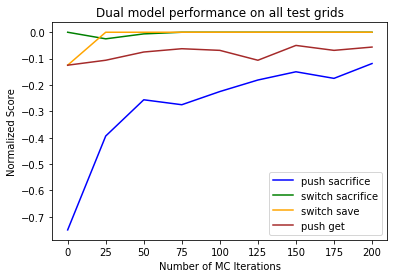

In [6]:
# Graphs impact of iterations on dual model performance for each grid type 

plt.plot(ITERS, dual_type_dict[100], label='push sacrifice', color="blue")
plt.plot(ITERS, dual_type_dict[200], label='switch sacrifice', color="green")
plt.plot(ITERS, dual_type_dict[300], label='switch save', color="orange")
plt.plot(ITERS, dual_type_dict[400], label='push get', color="brown")
plt.legend()
plt.xlabel("Number of MC Iterations")
plt.ylabel("Normalized Score")
plt.title("Dual model performance on all test grids")
plt.show()

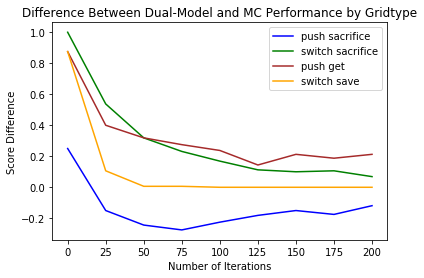

In [7]:
# Graphs difference between dual model and monte-carlo model for each grid type and varying iterations

grid_score_diff = defaultdict(list)

for grid in TEST_GRIDS.keys():
    difference = []
    zip_obj = zip(dual_scores[grid], mc_scores[grid])
    for dual_score, mc_score in zip_obj:
        difference.append(dual_score - mc_score)
    grid_score_diff[grid//100*100].append(difference)
     
for grid_type,diff in grid_score_diff.items():
    diff = np.array(diff)
    size = diff.shape[0]
    grid_score_diff[grid_type] = np.sum(diff,axis=0)/size
        
plt.plot(ITERS, grid_score_diff[100], label='push sacrifice', color="blue")
plt.plot(ITERS, grid_score_diff[200], label='switch sacrifice', color="green")
plt.plot(ITERS, grid_score_diff[400], label='push get', color="brown")
plt.plot(ITERS, grid_score_diff[300], label='switch save', color="orange")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Score Difference")
plt.title("Difference Between Dual-Model and MC Performance by Gridtype")
plt.show()

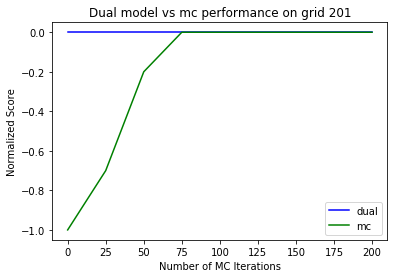

In [8]:
# Graph difference between dual model and monte-carlo moodel for for a given test grid (to explore finer grained differences)

def graph_one(num, dual_scores, mc_scores):
    plt.plot(ITERS, dual_scores[num], label='dual', color="blue")
    plt.plot(ITERS, mc_scores[num], label='mc', color="green")
    plt.legend()
    plt.xlabel("Number of MC Iterations")
    plt.ylabel("Normalized Score")
    plt.title("Dual model vs mc performance on grid " + str(num))
    plt.show()

graph_one(201,dual_scores,mc_scores)
#101, 107